In [5]:
# carico la traccia audio 
import librosa 
wav_file = 'speechsample.wav'
data, sr = librosa.load(wav_file, sr=None)
print(data.shape)
print(sr)

(64000,)
16000


Dopo aver caricato la forma d'onda, possiamo procedere alla divisione in finestre, dal momento che per il calcolo della LPC dobbimo sempre fare analisi short time!

In [27]:
frame_length = int(0.030 * sr) # 50ms window, 800 campioni
print(frame_length)
hop_size = int(0.015 * sr) # 25ms hop_length, hop di 320 campioni
print(hop_size)

480
240


In [28]:
import numpy as np 
import scipy.signal.windows as windows

def framing(signal, frame_length, hop_size):
    # per calcolare il numero di finestre devo fare (lunghezza segnale - lunghezza frame)/(frame hop, sovrapposizione)
    num_frames = int(np.floor((len(signal)-frame_length)/hop_size)+1)
    print(f"Num frames: {num_frames}")
    zc = np.zeros(num_frames)
    window = windows.hann(frame_length)
    frames = []
    for i in range(num_frames):
        start = i * hop_size
        end = min(start+frame_length, len(signal))
        frame = np.zeros(frame_length)
        frame[:end-start] = signal[start:end] # riempio il frame, eventualmente con del padding
        frame = frame * window # applico la finestra
        frames.append(frame)
    return frames

In [29]:
frames = framing(signal=data, frame_length=frame_length, hop_size=hop_size)
len(frames)

Num frames: 265


265

In [30]:
# adesso applico il filtro lineare
import matplotlib.pyplot as plt
import scipy

a = librosa.lpc(data, order=24)
b = np.hstack([[0], -1 * a[1:]])
y_hat = scipy.signal.lfilter(b, [1], data)

Text(0.5, 1.0, 'LP Model Forward Prediction')

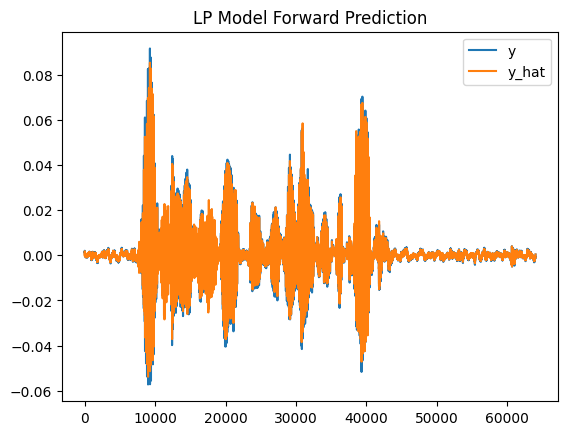

In [13]:
fig, ax = plt.subplots()
ax.plot(data)
ax.plot(y_hat, linestyle='-')
ax.legend(['y', 'y_hat'])
ax.set_title('LP Model Forward Prediction')

In [31]:
import soundfile as sf
sf.write('output_funzione.wav', y_hat, sr)

In [81]:
def lpc_overlap_add(frames, lpc_order=24, hop_size=None):
    num_frames, frame_length = frames.shape
    if hop_size is None:
        hop_size = frame_length // 2  # 50% di overlap
    total_length = hop_size * (num_frames - 1) + frame_length
    reconstructed_signal = np.zeros(total_length)
    window = np.hamming(frame_length)  # stessa finestra usata prima

    for i, frame in enumerate(frames):
        # Calcola i coefficienti LPC per il frame
        a = librosa.lpc(frame, order=lpc_order)
        # print(a)
        b = np.hstack([[0], -1 * a[1:]])
        # print(b)
        # Stima il segnale a partire dall’LPC (usando l’inverso del filtro)
        # Generiamo l’eccitazione residua come rumore bianco o primo sample
        frame_hat = scipy.signal.lfilter(b, [1], frame)
        frame_hat *= window
        # Overlap-add nel segnale completo
        start = i * hop_size
        reconstructed_signal[start:start + frame_length] += frame_hat

    return reconstructed_signal

In [82]:
data_ricostruito = lpc_overlap_add(frames=np.array(frames), lpc_order=16, hop_size=hop_size)

Text(0.5, 1.0, 'LP Model Forward Prediction')

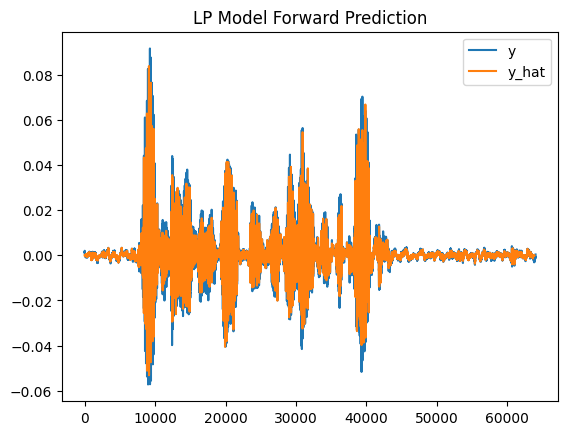

In [83]:
fig, ax = plt.subplots()
ax.plot(data)
ax.plot(data_ricostruito, linestyle='-')
ax.legend(['y', 'y_hat'])
ax.set_title('LP Model Forward Prediction')

In [35]:
import soundfile as sf
sf.write('output_calcolo.wav', data_ricostruito, sr)

In [68]:
mse_frames = []

for i in range(len(frames)):
    start = i * hop_size
    end = start + frame_length

    frame_orig = data[start:end]
    frame_recon = data_ricostruito[start:end]

    # Padding se frame all'ultimo giro è più corto
    min_len = min(len(frame_orig), len(frame_recon))
    mse = np.mean((frame_orig[:min_len] - frame_recon[:min_len]) ** 2)
    mse_frames.append(mse)

mse_frames = np.array(mse_frames)

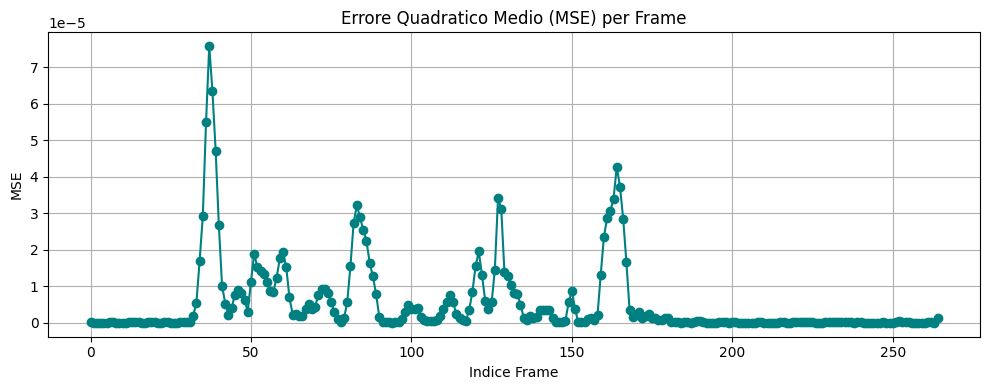

In [69]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 4))
plt.plot(mse_frames, marker='o', linestyle='-', color='teal')
plt.title("Errore Quadratico Medio (MSE) per Frame")
plt.xlabel("Indice Frame")
plt.ylabel("MSE")
plt.grid(True)
plt.tight_layout()
plt.show()